# Homework 2

### Due Date: Friday, March 20

### Policy Gradient

In this assignment, we will implement vanilla policy gradient algorithm (REINFORCE) covered in the lecture. You will work on i) a function approximator, ii) computing action, iii) collecting samples, iV) training the agent, V) plotting the resutls. 


***Complete the missing operations and test your implemented algorithm on the Gym environment.***

***Software requirements:***
- Python >= 3.6
- Tensorflow version <= 1.15.3 (1.X version)
- OpenAI Gym

- Training the agent (policy) can take long time. It is recomended to start solving the problems earlier.

- Save any plots you generated in this notebook. The grade will be given based on the plots you showed.



Make sure the packages you installed meet the requirements.

In [1]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [2]:
import gym
gym.__version__

'0.18.0'

## 1.1 Tensorflow Implementation

We will be implementing policy gradient algorithm using Tensorflow 1.X., which simply updates the parameters of policy from obtaining gradient estimates. The core of policy gradient is to design a function approximator, computing actions, collecting samples, and training the policy. In the below cell, you are encouraged to fill in the components that are missing. ***Your tasks*** are 

1. Complete the 'create_model' method to output the mean value for diagonal Guassian policy. Covariance is already defined in the model, so focus on creating neural network model.

2. Complete the 'action_op' method to calculate and return the actions for diagonal Gaussian policy. The applied action should be $\pi(s) = \pi_{\text{mean}}(s) + exp(logstd) * \mathcal{N}(0,1)$

***Hints***:
- Some useful tensorflow classes and methods include: 'tf.exp', 'tf.random_normal'



***IF you are using MAC, please run below box***

In [3]:
import os
# MAC user only
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
import tensorflow as tf
import numpy as np
import os
import ipdb


class PolicyOpt(object):

    def __init__(self, env, linear=False, stochastic=True, hidden_size=32, nonlinearity=tf.nn.relu):
        """Instantiate the policy iteration class.

        This initializes the policy optimization with a set of trainable 
        parameters, and creates a tensorflow session.

        Attributes
        ----------
        env : gym.Env
            the environment that the policy will be trained on
        linear : bool, optional
            specifies whether to use a linear or neural network 
            policy, defaults to False (i.e. Fully-Connected-Neural-Network)
        stochastic : bool, optional
            specifies whether to use a stochastic or deterministic 
            policy, defaults to True
        hidden_size : list of int, optional
            list of hidden layers, with each value corresponding 
            to the number of nodes in that layer 
        nonlinearity : tf.nn.*
            activation nonlinearity
        """
        
        # clear computation graph
        tf.reset_default_graph()
        
        # set a random seed
        tf.set_random_seed(1234)
        
        # start a tensorflow session
        self.sess = tf.Session()
        
        # environment to train on
        self.env = env
        
        # number of elements in the action space
        self.ac_dim = env.action_space.shape[0]
        
        # number of elements in the observation space
        self.obs_dim = env.observation_space.shape[0]

        # actions placeholder
        self.a_t_ph = tf.placeholder(dtype=tf.float32, 
                                     shape=[None, self.ac_dim])
        # state placeholder
        self.s_t_ph = tf.placeholder(dtype=tf.float32, 
                                     shape=[None, self.obs_dim])
        # expected reward placeholder
        self.rew_ph = tf.placeholder(dtype=tf.float32, 
                                     shape=[None])

        # specifies whether the policy is stochastic
        self.stochastic = stochastic

        # policy that the agent executes during training/testing
        self.policy = self.create_model(
            args={
                "num_actions": self.ac_dim,
                "hidden_size": hidden_size,
                "linear": linear,
                "nonlinearity": nonlinearity,
                "stochastic": stochastic,
                "scope": "policy",
            }
        )
        
        # define symbolic action
        self.symbolic_action = self.action_op()

        # initialize all variables
        self.sess.run(tf.global_variables_initializer())

        # create saver to save model variables
        self.saver = tf.train.Saver()

    def create_model(self, args):
        """Create a model for your policy or other components.

        Parameters
        ----------
        args : dict
            model-specific arguments, with keys:
              - "stochastic": True by default
              - "hidden_size": Number of neurons in hidden layer
              - "num_actions" number of output actions
              - "scope": scope of the model

        Returns
        -------
        tf.Variable
            mean actions of the policy
        tf.Variable 
            logstd of the policy actions
        """

#################### Build Your Neural Network Here! ####################  

        layer_1 = tf.layers.dense(self.s_t_ph, args["hidden_size"], activation=args["nonlinearity"])
        layer_2 = tf.layers.dense(layer_1, 50, activation=tf.nn.relu)
        output_mean = tf.layers.dense(layer_2, args["num_actions"])  

        
##########################################################################        

        if args["stochastic"]:
            output_logstd =  tf.get_variable(name="action_logstd",shape=[self.ac_dim],trainable=True)
        else:
            output_logstd = None

        return output_mean, output_logstd
    
    def action_op(self):
        """
        Create a symbolic expression that will be used to compute actions from observations.

        When the policy is stochastic, the action follows 

            a_t = output_mean + exp(output_logstd) * z; z ~ N(0,1)
        """
        if self.stochastic:
            output_mean, output_logstd = self.policy

            #################### Implement a stochastic policy here ####################        
            # Implement a stochastic version of computing actions.       #
            #                                                            #
            # The action in a stochastic policy represented by           #
            # a diagonal Gaussian distribution with mean "M" and log     #
            # standard deviation "logstd" is computed as follows:        #
            #                                                            #
            #     a = M + exp(logstd) * z                                #
            #                                                            #
            # where z is a random normal value, i.e. z ~ N(0,1)          #
            #                                                            #
            # In order to generate numbers from a normal distribution,   #
            # use the `tf.random_normal` function.                       #
            ############################################################################ 
            symbolic_action = output_mean+tf.math.exp(output_logstd)*tf.random_normal([1])
            
        else:
            symbolic_action, _ = self.policy
        
        return symbolic_action

    def compute_action(self, obs):
        """Returns a list of actions for a given observation.

        Parameters
        ----------
        obs : np.ndarray
            observations

        Returns
        -------
        np.ndarray
            actions by the policy for a given observation
        """
        return self.sess.run(self.symbolic_action,feed_dict={self.s_t_ph: obs})

    def rollout(self, s_mean=None, s_std=None):
        """Collect samples from one rollout of the policy.

        Returns
        -------
        dict
            dictionary containing trajectory information for the rollout,
            specifically containing keys for "state", "action", "next_state", "reward", and "done"
        """
        states = []
        next_states = []
        actions = []
        rewards = []
        dones = []

        # start a new rollout by re-setting the environment and collecting the initial state
        state =  self.env.reset()

        steps = 0
        while True:
            steps += 1

            # compute the action given the state
            if s_mean is not None and s_std is not None:
                action = self.compute_action([(state - s_mean) / s_std])
            else:
                action = self.compute_action([state])
            action = action[0]

            # advance the environment once and collect the next state, reward, done, and info parameters from the environment
            next_state, reward, done, info =  self.env.step(action)

            # add to the samples list
            states.append(state)
            actions.append(action)
            next_states.append(next_state)
            rewards.append(reward)
            dones.append(done)

            state = next_state

            # if the environment returns a True for the done parameter,
            # end the rollout before the time horizon is met
            if done or steps > env._max_episode_steps:
                break

        # create the output trajectory
        trajectory = {"state": np.array(states, dtype=np.float32),
                      "reward": np.array(rewards, dtype=np.float32),
                      "action": np.array(actions, dtype=np.float32),
                      "next_state": np.array(next_states, dtype=np.float32),
                      "done": np.array(dones, dtype=np.float32)}

        return trajectory

    def train(self, args):
        """Abstract training method.

        This method will be filled in by algorithm-specific
        training operations in subsequent problems.

        Parameters
        ----------
        args : dict
            algorithm-specific hyperparameters
        """
        raise NotImplementedError



## 1.2 Tensorflow Interpretation

In order to test your implementation of the **stochastic policy**, run the below cell. The task is to interpret the code you implemented in previous section. If you implement correctly, you can see the value_1 and value_2.

***Question: How do you interpret value_1 and value_2 below cell?***


In [11]:
import gym
TEST_ENV = gym.make("Pendulum-v0")

alg = PolicyOpt(TEST_ENV, linear=False)
input_1 = [[0, 1, 2]]
value_1 = alg.sess.run(alg.policy[1], feed_dict={alg.s_t_ph: input_1})
value_2 = alg.compute_action(input_1)

In [12]:
value_1 # value 1 is the output[1] of the policy given an input 1

array([0.9644977], dtype=float32)

Answer:

In [10]:
value_2 #is the output of action_op function that calculates this expression from the policy output:                
        # output_mean + exp(output_logstd) * z; z ~ N(0,1)


array([[0.24253109]], dtype=float32)

Answer:

## 1.3 Implement Policy Gradient

In this section, we will implement REINFORCE algorithm presented in the lecture. As a review, the objective is optimize the parameters $\theta$ of some policy $\pi_\theta$ so that the expected return

\begin{equation}
J(\theta) = \mathbb{E} \bigg\{ \sum_{t=0}^T \gamma^t r(s_{t},a_{t}) \bigg\}
\end{equation}

is optimized. In this algorithm, this is done by calculating the gradient $\nabla_\theta J$ and applying a gradient descent method to find a better policy.

\begin{equation}
\theta ' = \theta + \alpha \nabla_\theta J(\theta)
\end{equation}

In the lecture, we derive how we compute $\nabla_{\theta} J(\theta)$. We can rewrite our policy gradient as:

\begin{equation}
\nabla_\theta J (\theta) \approx \frac{1}{N} \sum_{i=0}^{N} \bigg( \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta (a_{it} | s_{it}) \bigg) \bigg( \sum_{t=0}^T \gamma^{t}r_i(t) \bigg)
\end{equation}

Finally, taking into account the causality principle discussed in class, we are able to simplifiy the gradient estimate such as:

\begin{equation}
\nabla_\theta J (\theta) \approx \frac{1}{N} \sum_{i=0}^{N} \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta (a_{it} | s_{it}) \sum_{t'=t}^T \gamma^{t'-t}r_i(t')
\end{equation}

You will be implementing final expression in this assignment!



The process of REINFOCE algorithm follows:

1. Collect samples from current policy $\pi_\theta(s)$ by executing rollouts of the environment.
2. Calculate an estimate for the expected return at state $s_t$. 
3. Compute the log-likelihood of each action that was performed by the policy at every given step.
4. Estimate the gradient and update the parameters of policy using gradient-based technique.
5. Repeat steps 1-4 for a number of training iterations.

***Your task*** is to fill out the skeleton code for REINFORCE algorithm,

1. Complete the 'log_likelihoods' method to compute gradient of policy, $\nabla_{\theta}\pi_{\theta}$ for diagonal Guassian policy. 

2. Complete the 'compute_expected_return' method to calculate the reward-to-go, $\sum_{t^{\prime}=t}^{T}$. 



In [8]:
import tensorflow as tf
import numpy as np
import time
import tensorflow_probability as tfp

class REINFORCE(PolicyOpt):

    def train(self, num_iterations=1000, steps_per_iteration=1000, learning_rate=int(1e-4), gamma=0.95, 
              **kwargs):
        """Perform the REINFORE training operation.

        Parameters
        ----------
        num_iterations : int
            number of training iterations
        steps_per_iteration : int
            number of individual samples collected every training iteration
        learning_rate : float
            optimizer learning rate
        gamma : float
            discount rate
        kwargs : dict
            additional arguments

        Returns
        -------
        list of float
            average return per iteration
        """
        # set the discount as an attribute
        self.gamma = gamma
        
        # set the learning rate as an attribute
        self.learning_rate = learning_rate

        # create a symbolic expression to compute the log-likelihoods 
        log_likelihoods = self.log_likelihoods()

        # create a symbolic expression for updating the parameters of your policy
        self.opt, self.opt_baseline = self.define_updates(log_likelihoods)
        
        # initialize all variables
        self.sess.run(tf.global_variables_initializer())


        # average return per training iteration
        ret_per_iteration = []
        
        samples = []
        for i in range(num_iterations):
            
            # collect samples from the current policy
            samples.clear()
            steps_so_far = 0
            while steps_so_far < steps_per_iteration:
                new_samples = self.rollout()
                steps_so_far += new_samples["action"].shape[0]
                samples.append(new_samples)

            # compute the expected returns
            v_s = self.compute_expected_return(samples)

            # compute and apply the gradients
            self.call_updates(log_likelihoods, samples, v_s, **kwargs)

            # compute the average cumulative return per iteration
            average_rew = np.mean([sum(s["reward"]) for s in samples])

            # display iteration statistics
            print("Iteration {} return: {}".format(i, average_rew))
            ret_per_iteration.append(average_rew)

        return ret_per_iteration

    def log_likelihoods(self):
        """Create a tensorflow operation that computes the log-likelihood 
        of each performed action.
        """
        
        output_mean, output_logstd = self.policy

        ##############################################################
        # Create a tf operation to compute the log-likelihood of     #
        # each action that was performed by the policy               #
        #                                                            #
        # The log likelihood in the continuous case where the policy #
        # is expressed by a multivariate gaussian can be computing   #
        # using the tensorflow object:                               #
        #                                                            #
        #    p = tfp.distributions.MultivariateNormalDiag(           #
        #        loc=...,                                            #
        #        scale_diag=...,                                     #
        #    )                                                       #
        #                                                            #
        # This method takes as input a mean (loc) and standard       #
        # deviation (scale_diag), and then can be used to compute    #
        # the log-likelihood of a variable as follows:               #
        #                                                            #
        #    log_likelihoods = p.log_prob(...)                       #
        #                                                            #
        # For this operation, you will want to use placeholders      #
        # created in the __init__ method of problem 1.               #
        ##############################################################

        p = tfp.distributions.MultivariateNormalDiag(           
                loc=output_mean, scale_diag=output_logstd)
        log_likelihoods = p.log_prob(self.a_t_ph)

        return log_likelihoods

    def compute_expected_return(self, samples):
        """Compute the expected return from a given starting state.
        This is done by using the reward-to-go method.

        Parameters
        ----------
        rewards : list of list of float
            a list of N trajectories, with each trajectory contain T 
            returns values (one for each step in the trajectory)

        Returns
        -------
        list of float, or np.ndarray
            expected returns for each step in each trajectory
        """
        rewards = [s["reward"] for s in samples]
        ##############################################################
        # Estimate the expected return from any given starting state #
        # using the reward-to-go method.                             #
        #                                                            #
        # Using this method, the reward is estimated at every step   #
        # of the trajectory as follows:                              #
        #                                                            #
        #   r = sum_{t'=t}^T gamma^(t'-t) * r_{t'}                   #
        #                                                            #
        # where T is the time horizon at t is the index of the       #
        # current reward in the trajectory. For example, for a given #
        # set of rewards r = [1,1,1,1] and discount rate gamma = 1,  #
        # the expected reward-to-go would be:                        #
        #                                                            #
        #   v_s = [4, 3, 2, 1]                                       #
        #                                                            #
        # You will be able to test this in one of the cells below!   #
        ##############################################################
        #v_s = [5,3,2,1]
        #vs = [r*(len(reward)-i)*pow(gamma,(len(rewards)-i)) for i,r in enumerate(rewards)]
        v_s = [sum(r[i:])*pow(self.gamma,(len(rewards)-i)) for r in rewards for i in range(len(r))]
        return v_s

    def define_updates(self, log_likelihoods):
        """Create a tensorflow operation to update the parameters of 
        your policy.

        Parameters
        ----------
        log_likelihoods : tf.Operation
            the symbolic expression you created to estimate the log 
            likelihood of a set of actions

        Returns
        -------
        tf.Operation
            a tensorflow operation for computing and applying the 
            gradients to the parameters of the policy
        None
            the second component is used in problem 2.b, please ignore 
            for this problem
        """

        loss = - tf.reduce_mean(tf.multiply(log_likelihoods, self.rew_ph))
        opt = tf.train.AdamOptimizer(self.learning_rate).minimize(loss)

        return opt, None

    def call_updates(self, log_likelihoods, samples, v_s, **kwargs):
        """Apply the gradient update methods in a tensorflow session.

        Parameters
        ----------
        log_likelihoods: tf.Operation
            the symbolic expression you created to estimate the log 
            likelihood of a set of actions
        samples : list of dict
            a list of N trajectories, with each trajectory containing 
            a dictionary of trajectory data (see self.rollout)
        v_s : list of float, or np.ndarray
            the estimated expected returns from your
            `comput_expected_return` function 
        kwargs : dict
            additional arguments (used in question 3)
        """
        # concatenate the states
        states = np.concatenate([s["state"] for s in samples])

        # concatenate the actions
        actions = np.concatenate([s["action"] for s in samples])

        # execute the optimization step
        self.sess.run(self.opt, feed_dict={self.s_t_ph: states,
                                           self.a_t_ph: actions,
                                           self.rew_ph: v_s})

Check your 'log_likelihoods' method by running below cell:

In [9]:
alg = REINFORCE(TEST_ENV, stochastic=True)

log_likelihoods = alg.log_likelihoods()

# collect a sample output for a given input state
input_s = [[0, 0, 0], [0, 1, 2], [1, 2, 3]]
input_a = [[0], [1], [2]]

# Check
computed = alg.sess.run(log_likelihoods, feed_dict={alg.a_t_ph: input_a, alg.s_t_ph: input_s})

In [10]:
computed

array([-0.8827907, -1.0238237, -1.3920786], dtype=float32)

Test your 'compute_expected_return' by running below cell:

In [11]:
# 1. Test the non-normalized case
alg = REINFORCE(TEST_ENV, stochastic=True)
alg.gamma = 1.0
    
input_1 = [{"reward": [1, 1, 1, 1]},
           {"reward": [1, 1, 1, 1]}]
vs_1 = alg.compute_expected_return(samples=input_1)
ans_1 = np.array([4, 3, 2, 1, 4, 3, 2, 1])

if np.linalg.norm(vs_1 - ans_1) < 1e-3:
    print('Great job!')
else:
    print('Check your implementation (compute_expected_return)')

    

Great job!


## 1.4 Testing your algorithm

When you are ready, test your policy gradient algorithms on the *Pendulum-v0* environment in the cell below. *Pendulum-v0* environment is similar to *off-shore wind power*, the goal here is to maintain the Pendulum is upright using control input. The best policy should get around -200 scores. ***Your task*** is to run your REINFORCE algorithm and plot the result!


In [12]:
# set this number as 1 for testing your algorithm, and 3 for plotting
NUM_TRIALS = 3

# ===========================================================================
# Do not modify below line
# ===========================================================================

# we will test the algorithms on the Pendulum-v0 gym environment
import gym
env = gym.make("Pendulum-v0")

# train on the REINFORCE algorithm
import numpy as np
r = []
for i in range(NUM_TRIALS):
    print("\n==== Training Run {} ====".format(i))
    alg = REINFORCE(env, stochastic=True)
    res = alg.train(learning_rate=0.005, gamma=0.95, num_iterations=500, steps_per_iteration=15000)
    r.append(np.array(res))
    alg = None

# save results
np.savetxt("InvertedPendulum_results.csv", np.array(r), delimiter=",")


==== Training Run 0 ====
Iteration 0 return: -1250.6426841695607
Iteration 1 return: -1140.2230289396518
Iteration 2 return: -1109.7723370533056
Iteration 3 return: -1147.1293808423106
Iteration 4 return: -1156.0942307918099
Iteration 5 return: -1149.0448403058379
Iteration 6 return: -1135.6469043124218
Iteration 7 return: -1166.807921275068
Iteration 8 return: -1163.5457119794298
Iteration 9 return: -1145.0513377646296
Iteration 10 return: -1176.422530351424
Iteration 11 return: -1184.3164525238549
Iteration 12 return: -1136.8767126731263
Iteration 13 return: -1158.8047559186443
Iteration 14 return: -1166.5381146606337
Iteration 15 return: -1128.9804771378979
Iteration 16 return: -1150.9142264323095
Iteration 17 return: -1125.6936555994769
Iteration 18 return: -1157.5958686106985
Iteration 19 return: -1133.9703269950517
Iteration 20 return: -1172.2130679867928
Iteration 21 return: -1150.9238949426513
Iteration 22 return: -1157.8235940697084
Iteration 23 return: -1129.5229863186476
It

Iteration 200 return: -256.97541554668317
Iteration 201 return: -234.82526867013632
Iteration 202 return: -226.37076307638372
Iteration 203 return: -264.4791654865833
Iteration 204 return: -269.40698351784175
Iteration 205 return: -209.29476021223252
Iteration 206 return: -255.83390959263247
Iteration 207 return: -254.20742352660082
Iteration 208 return: -223.64780052528965
Iteration 209 return: -271.82660613195316
Iteration 210 return: -245.76449441606383
Iteration 211 return: -245.96929444666563
Iteration 212 return: -273.5828041632195
Iteration 213 return: -234.3729962908029
Iteration 214 return: -262.9612759970059
Iteration 215 return: -258.09965093196854
Iteration 216 return: -225.72845830853058
Iteration 217 return: -255.82456993484539
Iteration 218 return: -245.11363260692588
Iteration 219 return: -208.5560137183908
Iteration 220 return: -298.76241915884316
Iteration 221 return: -245.84065937146582
Iteration 222 return: -243.75331977886108
Iteration 223 return: -265.351154587032

Iteration 397 return: -247.00103192973737
Iteration 398 return: -207.96965275588082
Iteration 399 return: -209.52748868723847
Iteration 400 return: -220.8956539118486
Iteration 401 return: -268.8558881208765
Iteration 402 return: -199.7776985432122
Iteration 403 return: -211.59208340661567
Iteration 404 return: -220.79810533668197
Iteration 405 return: -222.58677860742873
Iteration 406 return: -258.7266856499791
Iteration 407 return: -242.0570204577073
Iteration 408 return: -237.39141452278815
Iteration 409 return: -203.87821295658605
Iteration 410 return: -253.30014530731233
Iteration 411 return: -225.6717029417508
Iteration 412 return: -216.39625242798726
Iteration 413 return: -233.33140391430075
Iteration 414 return: -229.07822397971913
Iteration 415 return: -238.6569194020293
Iteration 416 return: -251.43220534131115
Iteration 417 return: -245.25936453874058
Iteration 418 return: -266.4219043302773
Iteration 419 return: -218.92961582344802
Iteration 420 return: -218.10028401701734


Iteration 96 return: -825.863192274565
Iteration 97 return: -789.5506800224978
Iteration 98 return: -845.6301759909982
Iteration 99 return: -823.0772580623425
Iteration 100 return: -805.3628400808457
Iteration 101 return: -785.0118690404524
Iteration 102 return: -798.8535780973401
Iteration 103 return: -754.3649102504054
Iteration 104 return: -668.8050154381308
Iteration 105 return: -666.5492659446735
Iteration 106 return: -605.4596481292051
Iteration 107 return: -683.537624664839
Iteration 108 return: -566.341310543239
Iteration 109 return: -593.8639046092925
Iteration 110 return: -535.6983298702612
Iteration 111 return: -550.2647667824135
Iteration 112 return: -479.60996205554693
Iteration 113 return: -511.2787136463398
Iteration 114 return: -545.5763473040543
Iteration 115 return: -527.0335288983456
Iteration 116 return: -563.8416565527941
Iteration 117 return: -622.1587607125895
Iteration 118 return: -715.556383496026
Iteration 119 return: -717.5663267261344
Iteration 120 return: -

Iteration 295 return: -326.0410259796777
Iteration 296 return: -285.0394473712908
Iteration 297 return: -336.0727856589155
Iteration 298 return: -254.11523484678492
Iteration 299 return: -286.2803705191453
Iteration 300 return: -289.4923788607475
Iteration 301 return: -304.51803486639
Iteration 302 return: -256.3611362337682
Iteration 303 return: -257.28383196881134
Iteration 304 return: -285.1523400746584
Iteration 305 return: -290.29068558297274
Iteration 306 return: -310.7955709258744
Iteration 307 return: -312.7448707648109
Iteration 308 return: -275.8097502187092
Iteration 309 return: -303.23263496432577
Iteration 310 return: -280.8253229349524
Iteration 311 return: -302.82945441961743
Iteration 312 return: -286.1708749216194
Iteration 313 return: -279.1735383170325
Iteration 314 return: -326.0984493347114
Iteration 315 return: -307.30895377171345
Iteration 316 return: -273.7746990762083
Iteration 317 return: -255.36280149343685
Iteration 318 return: -299.7272409332878
Iteration 3

Iteration 493 return: -205.11584167592963
Iteration 494 return: -243.51894912907377
Iteration 495 return: -261.5967163819924
Iteration 496 return: -275.98721930804476
Iteration 497 return: -239.48592910741942
Iteration 498 return: -243.78556344870705
Iteration 499 return: -266.14591397050503

==== Training Run 2 ====
Iteration 0 return: -1252.3020511585598
Iteration 1 return: -1164.6447176698255
Iteration 2 return: -1131.1626251083953
Iteration 3 return: -1125.6901816568773
Iteration 4 return: -1185.1278502481027
Iteration 5 return: -1112.8316345185872
Iteration 6 return: -1199.944664440987
Iteration 7 return: -1172.913531483366
Iteration 8 return: -1177.454774044926
Iteration 9 return: -1186.4049309592942
Iteration 10 return: -1144.13102349064
Iteration 11 return: -1165.710251942873
Iteration 12 return: -1082.5450863686174
Iteration 13 return: -1141.7231667017502
Iteration 14 return: -1113.3258678249176
Iteration 15 return: -1111.3609835035788
Iteration 16 return: -1132.9734850292373


Iteration 194 return: -322.54571206036417
Iteration 195 return: -285.3880468931382
Iteration 196 return: -288.06965069689693
Iteration 197 return: -314.4995011881828
Iteration 198 return: -319.1715119546663
Iteration 199 return: -271.4658243250578
Iteration 200 return: -275.23522787866244
Iteration 201 return: -292.0299597188871
Iteration 202 return: -305.535545461037
Iteration 203 return: -286.79686615281173
Iteration 204 return: -320.93072894551045
Iteration 205 return: -286.19964841527116
Iteration 206 return: -288.96394773936106
Iteration 207 return: -297.5767981766215
Iteration 208 return: -261.2951092750334
Iteration 209 return: -297.23120372700816
Iteration 210 return: -307.63597443172705
Iteration 211 return: -320.53847434375757
Iteration 212 return: -261.38683940773103
Iteration 213 return: -323.73319987086893
Iteration 214 return: -280.6794072134525
Iteration 215 return: -249.1715225065733
Iteration 216 return: -347.54050399291054
Iteration 217 return: -293.4687265858763
Iter

Iteration 392 return: -263.95703333085504
Iteration 393 return: -243.07256222436132
Iteration 394 return: -268.76525586477794
Iteration 395 return: -283.7993771900774
Iteration 396 return: -282.299138362419
Iteration 397 return: -237.97311795906097
Iteration 398 return: -272.97011538354565
Iteration 399 return: -237.5383493945556
Iteration 400 return: -242.06794758095978
Iteration 401 return: -287.858675557912
Iteration 402 return: -279.6574142383022
Iteration 403 return: -247.7807906568489
Iteration 404 return: -248.40872867573398
Iteration 405 return: -293.96646064344355
Iteration 406 return: -263.58701377849826
Iteration 407 return: -260.6351159787256
Iteration 408 return: -286.9975172086334
Iteration 409 return: -263.6608040632043
Iteration 410 return: -267.50565584937846
Iteration 411 return: -231.40245910929855
Iteration 412 return: -287.83544977065475
Iteration 413 return: -242.90753041260498
Iteration 414 return: -274.34584896272236
Iteration 415 return: -238.6905174764772
Iter

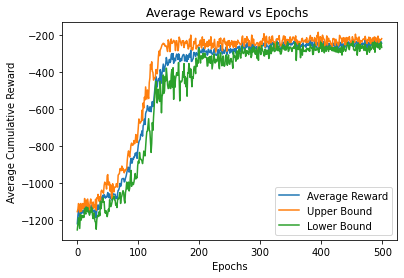

In [13]:
# collect saved results
import numpy as np
r1 = np.genfromtxt("InvertedPendulum_results.csv", delimiter=",")
all_results = [r1]
labels = ["REINFORCE"]

##############################################################
# Plot your Policy Gradient results below
##############################################################
import matplotlib.pyplot as plt
arrays = [np.array(x) for x in r1]
mean = [np.mean(k) for k in zip(*arrays)]
maximum = [np.max(k) for k in zip(*arrays)]
minimum = [np.min(k) for k in zip(*arrays)]
plt.plot(mean, label = "Average Reward")
plt.plot(maximum, label = "Upper Bound")
plt.plot(minimum, label = "Lower Bound")

plt.xlabel('Epochs')
# Set the y axis label of the current axis.
plt.ylabel('Average Cumulative Reward')
# Set a title of the current axes.
plt.title('Average Reward vs Epochs ')
# show a legend on the plot
plt.legend()

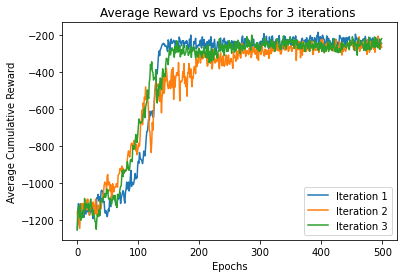

In [18]:
arrays = [np.array(x) for x in r1]
mean = [np.mean(k) for k in zip(*arrays)]
maximum = [np.max(k) for k in zip(*arrays)]
minimum = [np.min(k) for k in zip(*arrays)]
plt.plot(arrays[0], label = "Iteration 1")
plt.plot(arrays[1], label = "Iteration 2")
plt.plot(arrays[2], label = "Iteration 3")

plt.xlabel('Epochs')
# Set the y axis label of the current axis.
plt.ylabel('Average Cumulative Reward')
# Set a title of the current axes.
plt.title('Average Reward vs Epochs for 3 iterations ')
# show a legend on the plot
plt.legend()

In [53]:
arrays = [np.array(x) for x in r1]
[np.max(k) for k in zip(*arrays)]

[-1153.6859968996234,
 -1140.2230289396518,
 -1109.7723370533056,
 -1125.6901816568773,
 -1156.0942307918099,
 -1112.8316345185872,
 -1109.5659327033225,
 -1151.410759947903,
 -1129.515636083111,
 -1109.674647262326,
 -1136.5836769784264,
 -1136.1688743930442,
 -1082.5450863686174,
 -1123.5823234154532,
 -1113.3258678249176,
 -1091.3071866355526,
 -1132.9734850292373,
 -1085.3778558918414,
 -1110.7300081149924,
 -1133.9703269950517,
 -1151.554597377119,
 -1101.8367200199204,
 -1085.0502341901588,
 -1106.5405536456624,
 -1109.4277409644208,
 -1126.46751214051,
 -1101.2421910970286,
 -1135.5182698174162,
 -1119.0408270962257,
 -1119.972023323498,
 -1086.1695961087414,
 -1145.7721763771865,
 -1078.9699954006371,
 -1081.4111000064295,
 -1060.2482994511415,
 -1088.4030227634814,
 -1098.0829689908687,
 -1072.0769460101853,
 -1095.3646937387562,
 -1044.0399848488687,
 -1037.4532423910498,
 -1044.192935516429,
 -1048.626550968384,
 -1054.1916279255413,
 -1011.7851073607042,
 -993.9907855642649

In [17]:
arrays[0]

array([-1250.64268417, -1140.22302894, -1109.77233705, -1147.12938084,
       -1156.09423079, -1149.04484031, -1135.64690431, -1166.80792128,
       -1163.54571198, -1145.05133776, -1176.42253035, -1184.31645252,
       -1136.87671267, -1158.80475592, -1166.53811466, -1128.98047714,
       -1150.91422643, -1125.6936556 , -1157.59586861, -1133.970327  ,
       -1172.21306799, -1150.92389494, -1157.82359407, -1129.52298632,
       -1117.3730335 , -1160.91831528, -1191.4740652 , -1154.24627525,
       -1137.76226094, -1119.97202332, -1134.23839852, -1145.77217638,
       -1078.9699954 , -1081.41110001, -1060.24829945, -1088.40302276,
       -1098.08296899, -1072.07694601, -1096.57039787, -1044.03998485,
       -1037.45324239, -1044.19293552, -1048.62655097, -1103.07897071,
       -1099.83750524, -1149.10278828, -1161.88674533, -1148.47361518,
       -1164.48593199, -1180.42960577, -1162.86397017, -1140.28133567,
       -1152.00996773, -1089.68726985, -1123.05109489, -1126.81957767,
      

In [29]:
import gym
env = gym.make("Pendulum-v0")
alg = REINFORCE(env, stochastic=True)
res = alg.train(learning_rate=0.005, gamma=0.95, num_iterations=500, steps_per_iteration=15000)


Iteration 0 return: -1176.672904675665
Iteration 1 return: -1216.070022443294
Iteration 2 return: -1202.7490132704238
Iteration 3 return: -1192.1133482048435
Iteration 4 return: -1150.1559171369174
Iteration 5 return: -1175.6979074835808
Iteration 6 return: -1147.6036206579704
Iteration 7 return: -1170.4140696778304
Iteration 8 return: -1180.566206840739
Iteration 9 return: -1173.9213256384246
Iteration 10 return: -1162.0856930122695
Iteration 11 return: -1123.389557506116
Iteration 12 return: -1081.3361173125356
Iteration 13 return: -1083.3513626295887
Iteration 14 return: -1126.9422290097953
Iteration 15 return: -1134.3817024097903
Iteration 16 return: -1090.9773416251999
Iteration 17 return: -1092.1848565194198
Iteration 18 return: -1097.9710116537397
Iteration 19 return: -1104.3135218242153
Iteration 20 return: -1092.4861924437698
Iteration 21 return: -1119.253131153487
Iteration 22 return: -1125.8656160365729
Iteration 23 return: -1149.3907671681234
Iteration 24 return: -1158.0245

Iteration 201 return: -303.83947420473237
Iteration 202 return: -289.63777164116703
Iteration 203 return: -247.6417345573952
Iteration 204 return: -272.524448039401
Iteration 205 return: -294.18981498674714
Iteration 206 return: -282.8498741671
Iteration 207 return: -316.0783947183751
Iteration 208 return: -294.6612975531109
Iteration 209 return: -284.34711704108963
Iteration 210 return: -260.73246681788856
Iteration 211 return: -244.9213242970637
Iteration 212 return: -259.704750873135
Iteration 213 return: -330.9469633249419
Iteration 214 return: -279.6631845114073
Iteration 215 return: -251.44114336943875
Iteration 216 return: -280.7762685203804
Iteration 217 return: -251.27046506076664
Iteration 218 return: -265.5040556994265
Iteration 219 return: -290.89602422310776
Iteration 220 return: -279.3924148030481
Iteration 221 return: -273.0065919118637
Iteration 222 return: -277.75630557678323
Iteration 223 return: -285.9353746998324
Iteration 224 return: -282.4383741024068
Iteration 22

Iteration 399 return: -234.49120061489404
Iteration 400 return: -230.42907326605612
Iteration 401 return: -255.80010022247856
Iteration 402 return: -256.034285565452
Iteration 403 return: -241.8543080634423
Iteration 404 return: -263.77052237971935
Iteration 405 return: -243.6500137097767
Iteration 406 return: -256.8704163692485
Iteration 407 return: -269.0633947495273
Iteration 408 return: -259.7147233295584
Iteration 409 return: -258.73079836556815
Iteration 410 return: -269.2721389989191
Iteration 411 return: -239.4586613636296
Iteration 412 return: -298.10623085138593
Iteration 413 return: -250.75805831219924
Iteration 414 return: -239.79803569955018
Iteration 415 return: -266.42095710009096
Iteration 416 return: -241.38116710023382
Iteration 417 return: -268.7931202029759
Iteration 418 return: -272.2879849508338
Iteration 419 return: -253.91952693945552
Iteration 420 return: -300.4976608304382
Iteration 421 return: -250.3444531086159
Iteration 422 return: -226.61415200585955
Itera

In [43]:
for i_episode in range(1):
    observation = env.reset()
    for t in range(10000):
        env.render()
        print(observation)
        action = alg.compute_action(observation.reshape(1,3))
        #action = env.action_space.sample()
        print(action)
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

[-0.99988858  0.01492726 -0.42502619]
[[-0.55599374]]
[[-0.9992085 ]
 [ 0.03977885]
 [-0.4972298 ]]
[[1.2491729]]
[[-0.99855363]
 [ 0.05376431]
 [-0.2800196 ]]
[[0.21866187]]
[[-0.99794406]
 [ 0.06409103]
 [-0.20689699]]
[[-1.1028786]]
[[-0.99677384]
 [ 0.0802615 ]
 [-0.32426056]]
[[4.8273478]]
[[-0.9969164 ]
 [ 0.07847045]
 [ 0.03593552]]
[[1.5523735]]
[[-0.99806815]
 [ 0.06212895]
 [ 0.32764432]]
[[1.7207189]]
[[-0.99953336]
 [ 0.03054683]
 [ 0.6323488 ]]
[[-0.91345334]]
[[-0.9999892 ]
 [ 0.00463952]
 [ 0.51824063]]
[[0.9453262]]
[[-0.99959284]
 [-0.02853253]
 [ 0.66351914]]
[[1.6007528]]
[[-0.99736226]
 [-0.07258425]
 [ 0.8822326 ]]
[[3.4095542]]
[[-0.99168617]
 [-0.12868014]
 [ 1.1277944 ]]
[[6.3498497]]
[[-0.9809308 ]
 [-0.19435735]
 [ 1.3312842 ]]
[[6.08978]]
[[-0.9638034 ]
 [-0.26661384]
 [ 1.4855163 ]]
[[5.782338]]
[[-0.93966186]
 [-0.3421046 ]
 [ 1.5855559 ]]
[[7.777542]]
[[-0.9087136 ]
 [-0.41742024]
 [ 1.6289772 ]]
[[2.5693097]]
[[-0.8720602 ]
 [-0.48939866]
 [ 1.615912  ]]


[[ 0.99973583]
 [-0.02298374]
 [ 0.08981554]]
[[4.50141]]
[[ 0.9999905 ]
 [-0.00435667]
 [ 0.37257797]]
[[-0.700687]]
[[0.9999608 ]
 [0.0088535 ]
 [0.26420766]]
[[-2.7353058]]
[[ 0.99997264]
 [ 0.00739585]
 [-0.02915198]]
[[-0.65057683]]
[[ 0.9999991 ]
 [ 0.00133627]
 [-0.12119173]]
[[3.3082538]]
[[0.99994665]
 [0.01032638]
 [0.17981037]]
[[-4.3666506]]
[[ 0.9999889 ]
 [ 0.00470416]
 [-0.11244497]]
[[1.5268943]]
[[0.99994266]
 [0.01070973]
 [0.12011753]]
[[-0.51894426]]
[[0.99991256]
 [0.01322487]
 [0.05030807]]
[[-3.1887562]]
[[ 0.9999992 ]
 [ 0.00123661]
 [-0.23977304]]
[[-1.996215]]
[[ 0.9996704 ]
 [-0.02567421]
 [-0.5382776 ]]
[[2.4018142]]
[[ 0.9992569 ]
 [-0.03854399]
 [-0.257533  ]]
[[1.0256138]]
[[ 0.9989794 ]
 [-0.04516811]
 [-0.1325987 ]]
[[2.7795048]]
[[ 0.9992587 ]
 [-0.03849777]
 [ 0.13352546]]
[[0.44950676]]
[[ 0.9995529 ]
 [-0.02989878]
 [ 0.17207803]]
[[1.3068342]]
[[ 0.99992037]
 [-0.01261899]
 [ 0.345679  ]]
[[2.138166]]
[[0.9998158 ]
 [0.01919026]
 [0.636215  ]]
[[-2